Title: Project Milestone 1

Author: Chad Wood

Date: 11 Apr 2022

Modified By: Chad Wood

Description: This program demonstrates an introduction to my term project, most via wrangling and visualizing the spatial data I will be using. The goal of the project is to create a reinforcement learning model that can solve the traveling salesman problem.

#### Introduction

I will be testing a novel solution to the traveling salesman problem. Reinforcement learning will be applied to the task of finding the most efficient route between multiple locations. 

    Allow for:
        n = Total Number of Locations
        P(n) = Total Number of Permutations of Locations

Due to <i>P(n)</i> growing exponentially as <i>n</i> grows linearly, many traditional computers cannot handle the task of finding the most efficient route using conventional means (i.e., calculating the parameters for each permutation). This becomes the case at a relatively low number when compared to the amount of mail distributed daily within each US city. In fact, n=75 has more permutations than the largest estimation of atoms within the observable universe (2.4809140811395E+109 versus 10E+82, respectively). 

One solution to this problem (implemented by UPS) is to cluster the locations into groups of five and calculate the quickest route for each cluster, then clustering the clusters by the same manner (by five) and calculating the quickest route between them. This will continue until the total amount of combined clusters is less than or equal to five, and finally they are all combined. This approach minimizes the number of calculations necessary to find a suitable route, though it does not find the most efficient route. As a consequence of clustering locations, this algorithm fails to account for the possibility of more efficient routes that travel outside the boundaries set by the lowest-level clusters.

As a novel solution to this problem, I will be applying the capabilities of reinforcement learning. This approach is suitable to the problem because there is a lack of real-world training data to support most supervised training methodologies. For this milestone, I will be performing wrangling on the data I will be using to complete this task. 

##### Retrieving Data

Where available, the data describes each way with details such as the number of lanes, type of access, max speed-limit, etc. 
While it is true that much of this data is missing, this does not impact the project very much.

Geographic spatial data is available for each way (inherently), and that is what will prove most valuable from this data. The data's purpose here is to provide the spatial information pertaining to each way that can contribute to
the models output (the most efficient route). This spatial data is provided via the geometry column.

Below, I will first collect elements (e.g., buildings and stop signs), and afterwards I will collect the street network.

In [621]:
import osmnx as ox
import geopandas as gpd

# Place to query
center_point = (37.335796, -121.885254)

# Radius in meters
dist = 2000

# Tags to query by
element_tags = {
    'amenity': ['fuel'], # Gas-stations
    'building': ['retail', 'residential'], # Paracel target locations
    'highway': ['stop', 'traffic_signals'] # Stopsigns and stoplights 
}

# Creates generator for each tag {key: [values]}
queries = [{key: value} for key, value in element_tags.items()]

# Collects elements via each tag key individually to avoid timeout due to large requests
elements = [ox.geometries.geometries_from_point(center_point=center_point, tags=query, dist=dist)
            for query in queries]

gasstations, buildings, traffic_signals = [elem_type for elem_type in elements]
elements_df = elements[0].append(elements[1:])

C:\Users\mrcha\AppData\Local\Temp\ipykernel_8820\1124153242.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  elements_df = elements[0].append(elements[1:])


In [596]:
# Collects road network
G = ox.graph_from_point(center_point, dist=dist, network_type='drive_service')

# Converts network graph to geodataframe
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

##### Visualize Data

Below, I am demonstrating compatability between the street network and elements by plotting the nodes for stoplights and stopsigns over the street network. This takes place in the second subplot, as the first one just shows the street network data.

Elements within each tag:
    amenity: 15
    building: 127
    highway: 491


Text(0.5, 1.0, 'Stopsigns and Stoplights')

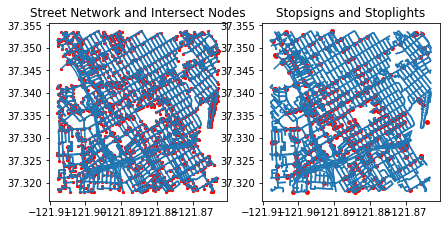

In [615]:
import matplotlib.pyplot as plt

print('Elements within each tag:')
for tag, geodata in zip(element_tags.keys(), elements):
    print(f'    {tag}: {len(geodata)}')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,7))

# Plot street network
edges.plot(ax=ax[0])
edges.plot(ax=ax[1])

# Plot street intersects
nodes.plot(markersize=5, ax=ax[0], color='red')
# Plot stopsigns and stoplights
traffic_signals.plot(markersize=15, ax=ax[1], color='red')

# Assign titles
ax[0].set_title("Street Network and Intersect Nodes")
ax[1].set_title("Stopsigns and Stoplights")

##### Creating a Route

Below, I demonstrate the ability to create a route between two nodes, using only data from the street network. I find the center and east-most nodes on the network and create a route between them.

In [619]:
# Get the x coordinates of the nodes
nodes['x'] = nodes["x"].astype(float)

# Get the Convex Hull of the network
convex_hull = edges.unary_union.convex_hull # Hull of network
centroid = convex_hull.centroid # Centroid of corvex hull
orig_xy = (centroid.y, centroid.x) # Get origin x and y coordinates

# Retrieve the most eastern node
maxx = nodes['x'].max() # Highest 'x' value (coordinate)
target = nodes.loc[nodes['x']==maxx, 'geometry'].values[0] # Returns geometry of node with max-x coord
target_xy = (target.y, target.x) # Get target x and y coordinates

# Find the node (id) in graph that is closest to origin point
orig_node = ox.get_nearest_node(G, orig_xy, method='euclidean')

# Find the node (id) in graph that is closest to target point
target_node = ox.get_nearest_node(G, target_xy, method='euclidean')

# Calculate the shortest path
route = nx.shortest_path(G=G, source=orig_node, target=target_node, weight='length')

print(f'Origin: {orig_xy}\nTarget: {target_xy}\n')
print(f'Origin Node ID: {orig_node}\nTarget Node ID: {target_node}\n')
print(f'Route: {route}')

Origin: (37.33578234867195, -121.8854454267764)
Target: (37.3493503, -121.8627317)

Origin Node ID: 5681157297
Target Node ID: 1081273289

Route: [5681157297, 3614216318, 5919589742, 3614216320, 3614216323, 4175909250, 3614216324, 3614216325, 5288352290, 4182147571, 281149296, 65551819, 65551821, 4878680389, 4878680387, 65467672, 65519591, 4878680394, 65430055, 65529806, 65460546, 65529810, 65529813, 7138278230, 7138278242, 65487649, 7330427723, 7330427718, 65421976, 7132735077, 7132735056, 65529814, 65494694, 7920340712, 65529815, 65529816, 65529817, 4915174310, 65529824, 8298953255, 8298953252, 1081273302, 1081273289]


C:\Users\mrcha\AppData\Local\Programs\Python\Python39\lib\site-packages\osmnx\distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
C:\Users\mrcha\AppData\Local\Programs\Python\Python39\lib\site-packages\osmnx\distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


##### Visualizing a Route

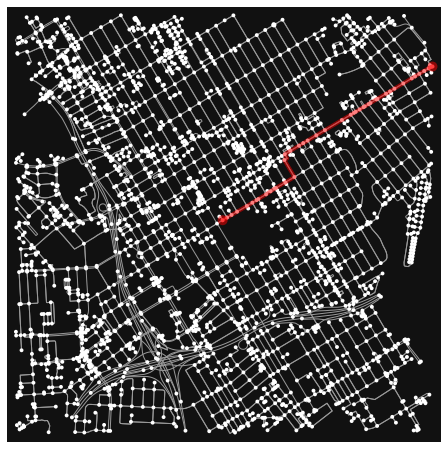

In [620]:
# Plot the shortest path
fig, ax = ox.plot_graph_route(G, route)